# Does Extreme Weather Trigger Extreme Actions? How Do Weather Conditions Influence the Occurrence of Domestic Crime in Chicago?

## Introduction

This project investigates the relationship between weather conditions and domestic crime in Chicago from 2010 to 2020, focusing on how environmental factors influence violent behaviour within households. Our research question—"How Do Weather Conditions Influence the Occurrence of Domestic Crime in Chicago?"—aims to uncover whether extreme weather events, such as heatwaves, cold snaps, or high humidity, exacerbate domestic violence. By exploring this relationship, we seek to provide insights into how environmental stressors impact household dynamics and contribute to criminal behaviour.

We integrate three datasets: the Chicago Crime dataset (Chicago Data Portal), Chicago Population data (US Census Bureau), and weather records from Chicago Midway International Airport. These sources provide a comprehensive view of crime patterns, demographic factors, and environmental conditions, allowing us to analyze whether domestic violence increases during severe weather events. Understanding this link has significant societal and economic implications. Societally, identifying weather-related triggers for domestic violence can help policymakers and social services develop targeted interventions, such as community outreach programs during extreme weather or public awareness campaigns about the risks of heightened aggression during heatwaves. Economically, reducing domestic crime through proactive measures can lower healthcare costs, decrease the burden on law enforcement, and improve overall community well-being.

Our analysis reveals that extreme temperatures—both high and low—are associated with higher domestic crime rates, likely due to heat-induced agitation and indoor confinement from the cold. Moderate humidity levels correlate with higher crime rates, while extremely high humidity appears to suppress domestic crime. Precipitation shows a weak relationship with crime, suggesting rainy days have little impact. These findings align with Ranson (2014), who found that extreme weather conditions, particularly temperature extremes, significantly influence crime rates. Understanding these patterns is critical for developing preventive measures, such as weather-based crime forecasts to allocate resources and support vulnerable communities during high-risk periods.

This study builds on existing research, such as Anderson et al. (2000), who demonstrated that high temperatures increase aggression, and Jacob et al. (2007), who highlighted the role of weather shocks in shaping criminal behaviour. If significant correlations emerge, our findings could inform targeted interventions, raising awareness of how weather conditions may heighten the risk of domestic violence and guiding strategies to mitigate harm.

#### Variables of Interest

The outcome variable (Y) is the daily domestic crime rate per 100,000 people, reflecting the frequency of domestic crimes reported in Chicago. This measure allows us to analyze how domestic crimes are distributed across the population and how weather conditions may influence behaviour.

We selected ten explanatory variables capturing key weather patterns: minimum, average, maximum temperature & humidity; maximum wind speed; minimum pressure; total precipitation; and maximum dew point. Temperature is central to our analysis, as extreme heat and cold have been linked to increased domestic violence, potentially due to indoor confinement and agitation. Humidity, particularly at extremes, may affect behaviour by causing discomfort and irritability. Maximum dew point measures heat stress, while low atmospheric pressure is associated with unsettled weather, potentially increasing stress. Precipitation forces individuals indoors, and maximum wind speed serves as a proxy for stormy conditions, both of which may heighten tensions. These variables allow us to examine how atmospheric conditions influence domestic crime in Chicago.

## Data Cleaning/Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

In [2]:
master_df = pd.read_csv("Crimes_-_2001_to_Present_20250126.csv")
master_df = master_df[(master_df['Year'] >= 2010) & (master_df['Year'] <= 2020)]

In [3]:
import datetime

weather_df = pd.read_csv("ChicagoFullWeatherData.csv")

weather_df["Date"] = pd.to_datetime(weather_df["Date"]).dt.date

In [4]:
ChicagoPop = pd.read_csv("ChicagoPop.csv")
ChicagoPop = ChicagoPop.drop(ChicagoPop.columns[[0, 1, 7, 8, 9, 11]], axis=1)
ChicagoPop = ChicagoPop.drop(index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], axis=1)

# Rename 'Variable observation date' to 'Year' in population dataset
ChicagoPop = ChicagoPop.rename(columns={'Variable observation date': 'Year'})

# Rename 'Variable observation value' to 'Population' in population dataset
ChicagoPop = ChicagoPop.rename(columns={'Variable observation value': 'Population'})

pop24_25 = pd.DataFrame({
    'Year': [2024, 2025],
    'Population': [2638159, 2746388], 
    'Variable observation metadata provenanceUrl': 
    ['https://worldpopulationreview.com/us-cities/illinois/chicago', 
     'https://nchstats.com/chicago-population/#:~:text=As%20of%202025%2C%20the%20population,city%20planning%20to%20cultural%20vibrancy.']
})

# Append the missing rows to the original dataset
ChicagoPop = pd.concat([ChicagoPop, pop24_25], ignore_index=True)

# Convert Year column to integer in the population dataset
ChicagoPop['Year'] = ChicagoPop['Year'].astype(int)
ChicagoPop = ChicagoPop[(ChicagoPop['Year'] >= 2010) & (ChicagoPop['Year'] <= 2020)]

In [5]:
CrimeData_df = master_df.dropna().copy()  # Drops rows with any missing values

# Convert 'DateTime' column to datetime format
CrimeData_df['DateTime'] = pd.to_datetime(CrimeData_df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

CrimeData_df = CrimeData_df[(CrimeData_df['Year'] >= 2010) & (CrimeData_df['Year'] <= 2020)]

CrimeData_df.rename(columns={"Date": "DateTime"})

# Merge the datasets based on Year
CrimeData_df = CrimeData_df.merge(ChicagoPop[['Year', 'Population']], on='Year', how='left')

# Extract the date (without time) to group by day
CrimeData_df['DateOnly'] = CrimeData_df['DateTime'].dt.date

CrimeData_df['DateOnly'] = pd.to_datetime(CrimeData_df['DateOnly']).dt.date

#drop Date as it is redundant
CrimeData_df.drop(columns="Date", inplace=True)

In [6]:
DomCrimeData_df = CrimeData_df.copy()
DomCrimeData_df = DomCrimeData_df[DomCrimeData_df['Domestic'] == True]

In [7]:
# Group by 'DateOnly' and count the number of crimes
DomDaily_crimes = DomCrimeData_df.groupby('DateOnly').size().reset_index(name='DomCrimeCount')

# Merge with population data (assuming the population is for each year)
DomDaily_crimes['Year'] = pd.to_datetime(DomDaily_crimes['DateOnly']).dt.year
DomDaily_crimes = DomDaily_crimes.merge(ChicagoPop[['Year', 'Population']], on='Year', how='left')

# Calculate the crime rate per day (Crimes per 100,000 people)
DomDaily_crimes['CrimeRate'] = (DomDaily_crimes['DomCrimeCount'] / DomDaily_crimes['Population'])*100000

# Merge the crime rate back to the original and domestic dataset using 'DateOnly'
DomCrimeData_df = DomCrimeData_df.merge(DomDaily_crimes[['DateOnly', 'DomCrimeCount']], on='DateOnly', how='left')
DomCrimeData_df = DomCrimeData_df.merge(DomDaily_crimes[['DateOnly', 'CrimeRate']], on='DateOnly', how='left')

In [8]:
# Merge on DATE
DomWeatherCrime_df = pd.merge(DomCrimeData_df, weather_df, left_on="DateOnly", right_on='Date', how='left')

DomWeatherCrime_df['DateOnly'] = pd.to_datetime(DomWeatherCrime_df['DateOnly'], errors='coerce')

DomWeatherCrime_df.drop(columns='DateOnly', inplace=True)

DomWeatherCrime_df = DomWeatherCrime_df.dropna()

## Summary Statistics Tables

In [19]:
columns_of_interest = ['CrimeRate', 'MinTemp', 'AvgTemp', 'MaxTemp', 'MaxDewPoint', 
                      'MaxHumidity', 'AvgHumidity', 'MinHumidity', 'MaxWindSpeed', 'MinPressure', 'TotalPrecipitation']
summary_stats = DomWeatherCrime_df[columns_of_interest].describe()

# Print table with formatting
print("Overall Summary Statistics:")
print("-" * 60)
for col in columns_of_interest:
    #print(f"{col}:")
    print(summary_stats[col].to_frame().T.round(2))
    print("-" * 60)

Overall Summary Statistics:
------------------------------------------------------------
              count  mean   std   min   25%   50%   75%    max
CrimeRate  569703.0  5.45  1.18  2.55  4.63  5.31  6.09  12.85
------------------------------------------------------------
            count   mean    std   min   25%   50%   75%   max
MinTemp  569703.0  46.69  19.27 -21.0  32.0  47.0  64.0  83.0
------------------------------------------------------------
            count   mean    std   min   25%   50%   75%   max
AvgTemp  569703.0  54.29  19.73 -15.8  38.4  56.0  72.3  92.8
------------------------------------------------------------
            count   mean    std   min   25%   50%   75%    max
MaxTemp  569703.0  61.91  21.01 -10.0  45.0  65.0  81.0  103.0
------------------------------------------------------------
                count   mean    std   min   25%   50%   75%   max
MaxDewPoint  569703.0  47.46  18.24 -21.0  33.0  49.0  64.0  79.0
-----------------------------------

The summary statistics provide an overview of crime rates and weather patterns in Chicago. The average crime rate is 5.45 per 100,000 people, with a maximum of 12.85, indicating significant variation. Temperature averages 54.29°F but ranges from -15.8°F to 92.8°F, with a standard deviation of 19.73°F, suggesting seasonal effects may influence crime trends. Humidity averages 66%, ranging from 23.6% to 99.4%, while wind speeds reach up to 51 mph. Precipitation is infrequent, with most days recording 0 inches, but can reach 4.22 inches on rainy days.

These statistics highlight the need to analyze crime trends across different weather conditions. Extreme weather events, from cold snaps to heatwaves, suggest patterns that could significantly impact domestic crime rates, consistent with Cohn & Rotton (2000), who found that weather variability influences crime occurrences.

#### Summary Table With Season Sub-Groups

In [25]:
# Define seasons
def assign_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Assign seasons
DomWeatherCrime_df["Season"] = DomWeatherCrime_df["Date"].apply(assign_season)

pd.set_option('display.max_rows', None)  # Show all rows

# Compute summary statistics for each season
seasonal_summary = DomWeatherCrime_df.groupby("Season")[columns_of_interest].describe()

# Print table with formatting
print("Seasonal Summary Statistics:")
print("=" * 80)
for season in seasonal_summary.index:
    print(f"Season: {season}")
    print("-" * 60)
    for col in columns_of_interest:
        print(f"{col}:")
        print(seasonal_summary.loc[season, col].to_frame().T.round(2))
        print("-" * 60)
    print("=" * 80)

Seasonal Summary Statistics:
Season: Fall
------------------------------------------------------------
CrimeRate:
         count  mean   std   min   25%   50%  75%   max
Fall  134877.0  5.12  0.91  2.82  4.42  5.02  5.7  8.22
------------------------------------------------------------
MinTemp:
         count   mean    std  min   25%   50%   75%   max
Fall  134877.0  48.23  13.71  0.0  38.0  48.0  59.0  79.0
------------------------------------------------------------
AvgTemp:
         count   mean    std   min   25%   50%   75%   max
Fall  134877.0  55.89  13.84  13.7  45.4  56.7  66.9  86.9
------------------------------------------------------------
MaxTemp:
         count   mean    std   min   25%   50%   75%   max
Fall  134877.0  63.45  15.15  18.0  52.0  65.0  75.0  95.0
------------------------------------------------------------
MaxDewPoint:
         count   mean    std  min   25%   50%   75%   max
Fall  134877.0  48.96  13.85  3.0  39.0  50.0  60.0  75.0
----------------------

Crime rates vary across seasons, with summer having the highest average rate (6.00) and winter the lowest (4.92). Summer also has the highest mean temperatures (74.97°F), while winter averages 29.56°F. Winter shows the highest standard deviation in crime rates (1.34), suggesting greater variability, potentially due to extreme weather. Humidity is highest in winter (71.54%), and precipitation is lowest (0.03 inches). Wind speeds peak in spring (18.29 mph). These seasonal variations highlight the potential influence of weather on crime rates, particularly extreme temperatures, as noted by Horrocks & Menclova (2011), who found that seasonal weather patterns significantly affect criminal behaviour.

## Plots, Histograms, Figures

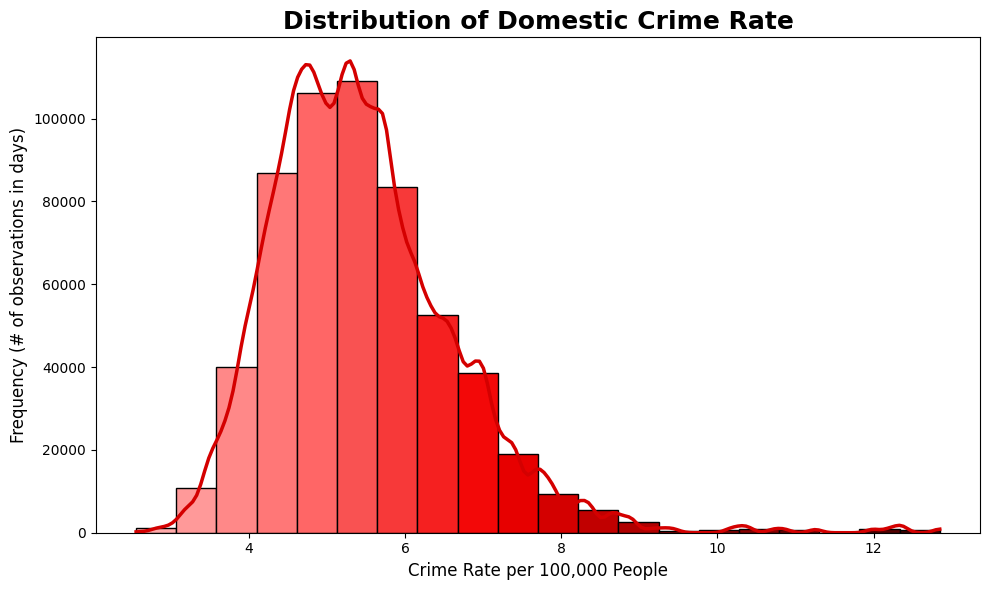

In [11]:
# Histogram for Crime Rate
# Reverse the gradient colors
red_gradient = [
    '#ffaaaa', '#ff9999', '#ff8888', '#ff7777', '#ff6666',  # Lighter reds
    '#f95252', '#f73939', '#f52020', '#f30808', '#e70000',  # Mid-range reds
    '#d40000', '#c10000', '#b00000', '#a00000', '#900000',  # Darker reds
    '#880000', '#770000', '#660000', '#550000', '#440000'   # Deep dark reds
]

# Create the figure
plt.figure(figsize=(10, 6))

# Create histogram with KDE
ax = sns.histplot(DomWeatherCrime_df['CrimeRate'], bins=20, kde=True, edgecolor='black', alpha=0.9)

# Apply gradient colors to bars
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(red_gradient[i % len(red_gradient)])

# Adjust the KDE line to be bold and red
for line in ax.lines:
    line.set_color('#d40000')  # Fitting deep red KDE color
    line.set_linewidth(2.5)  # Make the KDE line thicker for visibility

# Add title and labels
plt.title('Distribution of Domestic Crime Rate', fontsize=18, fontweight='bold')
plt.xlabel('Crime Rate per 100,000 People', fontsize=12)
plt.ylabel('Frequency (# of observations in days)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

**Figure 1**

This histogram shows the distribution of domestic crime rates in Chicago. The x-axis represents crime rates per 100,000 people, and the y-axis shows the frequency of days with those rates. The distribution is right-skewed, with most days having a crime rate between 4 and 6. The peak at 5 indicates stable crime rates on most days, but outliers with higher rates exist. This visualization provides a baseline of the frequency of domestic crimes across our observations.

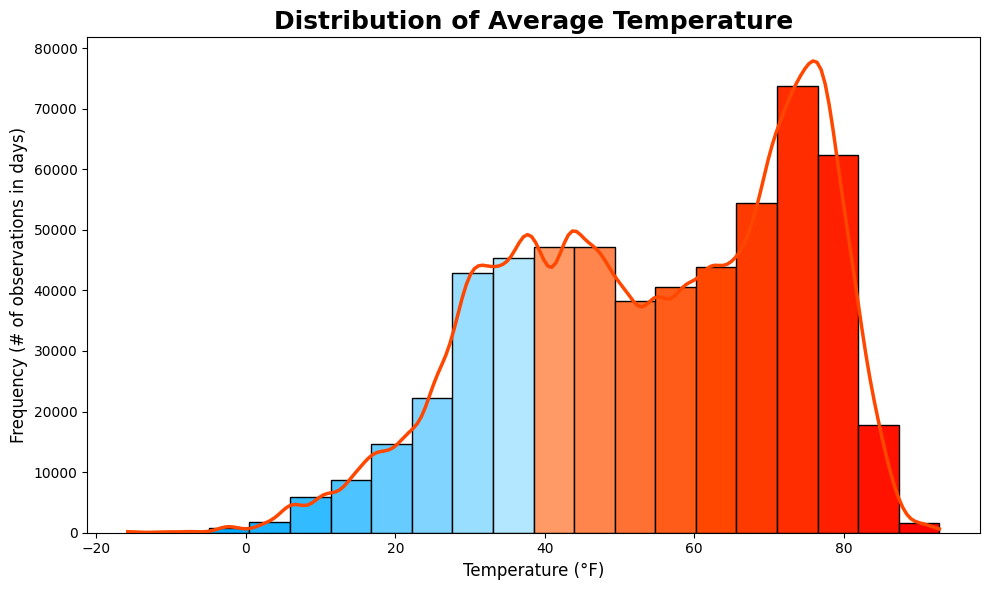

In [12]:
# Histogram for Temperature
# Define gradient colors for cold (light blue) to hot (red-orange)
temp_gradient = [
    '#0088ee', '#0099f7', '#00aaff', '#1ab2ff','#33bbff', # Mid-range blues
    '#4dc3ff', '#66ccff', '#80d4ff', '#99ddff', '#b3e6ff',  # Light blue (cold) 
    '#ff9966', '#ff854d', '#ff7033', '#ff5c1a', '#ff4700',  # Warm transition
    '#ff3a00', '#ff2d00', '#ff2000', '#ff1300', '#ff0600'   # Hot red-orange
]

# Create figure
plt.figure(figsize=(10, 6))

# Create histogram with KDE
ax = sns.histplot(DomWeatherCrime_df['AvgTemp'], bins=20, kde=True, edgecolor='black', alpha=0.9)

# Apply gradient colors to bars
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(temp_gradient[i % len(temp_gradient)])

# Adjust the KDE line to be bold and match the theme
for line in ax.lines:
    line.set_color('#ff4700')  # Deep red-orange KDE for heat effect
    line.set_linewidth(2.5)  # Make the KDE line thicker for visibility

# Add title and labels
plt.title('Distribution of Average Temperature', fontsize=18, fontweight='bold')
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Frequency (# of observations in days)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

**Figure 2**

This histogram shows the distribution of average temperatures in Chicago. The x-axis represents temperature in Fahrenheit, and the y-axis shows the frequency of days with those temperatures. The distribution is left-skewed, with most days between 70°F and 90°F. The peak at 75°F highlights moderate temperatures, while extreme temperatures are less common. This visualization helps analyze the spread of temperature across our observations.

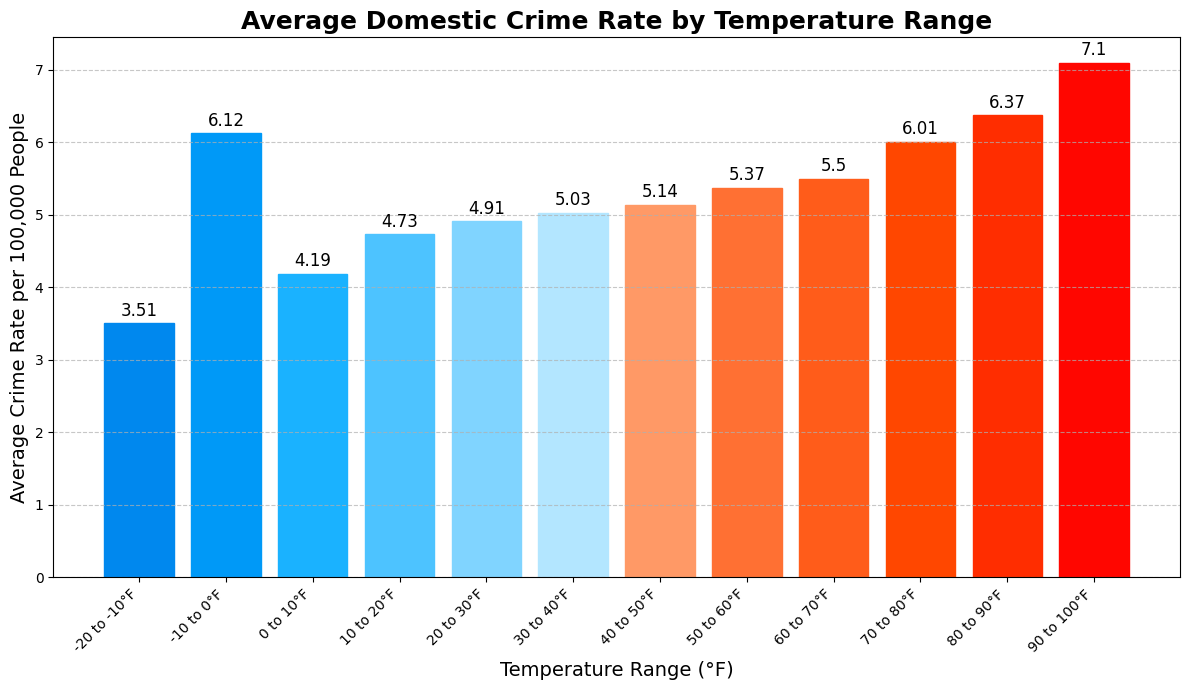

In [13]:
# Define temperature bins (from -20 to 100 in increments of 10)
# Define temperature bins (from -20 to 100 in increments of 10)
bins = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjusted temperature bins
labels = ['-20 to -10°F', '-10 to 0°F', '0 to 10°F', '10 to 20°F', '20 to 30°F', '30 to 40°F', '40 to 50°F', 
          '50 to 60°F', '60 to 70°F', '70 to 80°F', '80 to 90°F', '90 to 100°F']

# Create a new column for temperature bins
DomWeatherCrime_df['TempBin'] = pd.cut(DomWeatherCrime_df['AvgTemp'], bins=bins, labels=labels, right=False)

# Group by temperature bins and calculate the average crime rate for each bin
avg_crime_rate_by_temp = DomWeatherCrime_df.groupby('TempBin', observed=False)['CrimeRate'].mean()

# Define a gradient color scale from cold (light blue) to hot (red-orange)
temp_gradient = [
    '#0088ee', 
    '#0099f7',  
    '#1ab2ff',  
    '#4dc3ff', 
    '#80d4ff', 
    '#b3e6ff',  
    '#ff9966',
    '#ff7033',  
    '#ff5c1a',  
    '#ff4700',  
    '#ff2d00',  
    '#ff0600'   
]

# Plot the bar chart
plt.figure(figsize=(12, 7))

bars = plt.bar(avg_crime_rate_by_temp.index, avg_crime_rate_by_temp, edgecolor='black')

# Apply gradient colors to bars
for i, bar in enumerate(bars):
    bar.set_color(temp_gradient[i % len(temp_gradient)])

# Add value labels on top of the bars
for i, value in enumerate(avg_crime_rate_by_temp):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom', fontsize=12, color='black')

# Set the title and labels
plt.title("Average Domestic Crime Rate by Temperature Range", fontsize=18, fontweight='bold')
plt.xlabel("Temperature Range (°F)", fontsize=14)
plt.ylabel("Average Crime Rate per 100,000 People", fontsize=14)

# Rotate x-axis labels to make them readable
plt.xticks(rotation=45, ha='right')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

**Figure 3**

This bar chart shows the relationship between temperature and domestic crime rates. The x-axis categorizes temperature into bins, and the y-axis shows the average crime rate per 100,000 people. Crime rates increase with temperature, peaking at 7.1 in the 90°F-100°F range. However, crime rates are also high in the -10°F to 0°F range (6.12), suggesting both extreme heat and cold influence domestic crime, potentially due to forced proximity in indoor confinement and heat-induced agitation. This finding is consistent with Baryshnikova et al. (2021), who found that extreme temperatures, both hot and cold, significantly impact crime rates.

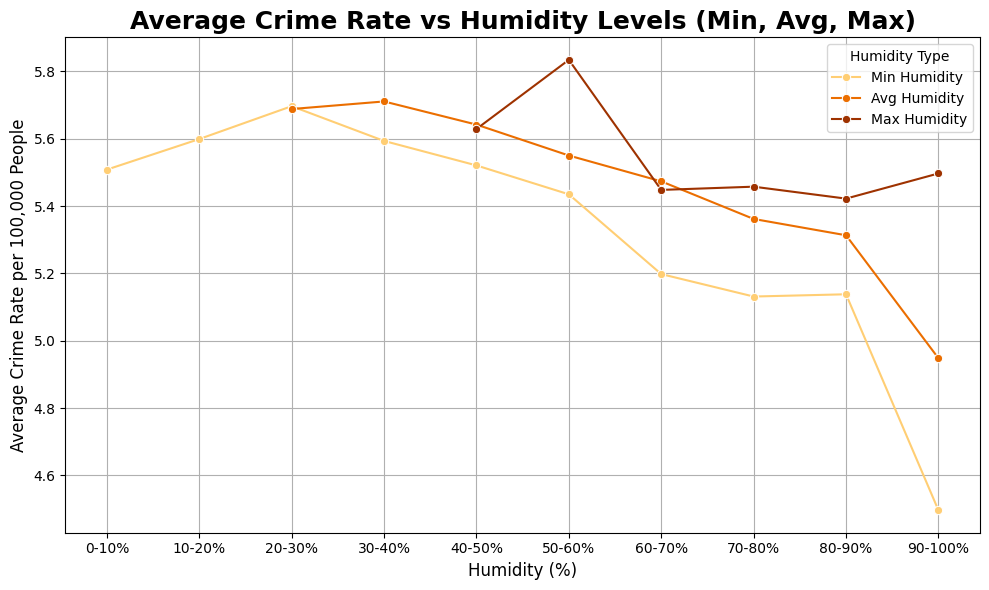

In [14]:
# Define the humidity bins (adjust as needed)
humidity_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
humidity_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Create binned columns for Min, Avg, and Max Humidity
DomWeatherCrime_df['MinHumidityBin'] = pd.cut(DomWeatherCrime_df['MinHumidity'], bins=humidity_bins, labels=humidity_labels, right=False)
DomWeatherCrime_df['AvgHumidityBin'] = pd.cut(DomWeatherCrime_df['AvgHumidity'], bins=humidity_bins, labels=humidity_labels, right=False)
DomWeatherCrime_df['MaxHumidityBin'] = pd.cut(DomWeatherCrime_df['MaxHumidity'], bins=humidity_bins, labels=humidity_labels, right=False)

# Calculate the average crime rate per humidity bin for Min, Avg, and Max Humidity
avg_crime_rate_min_humidity = DomWeatherCrime_df.groupby('MinHumidityBin', observed=False)['CrimeRate'].mean().reset_index()
avg_crime_rate_avg_humidity = DomWeatherCrime_df.groupby('AvgHumidityBin', observed=False)['CrimeRate'].mean().reset_index()
avg_crime_rate_max_humidity = DomWeatherCrime_df.groupby('MaxHumidityBin', observed=False)['CrimeRate'].mean().reset_index()

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Plot the binned data
sns.lineplot(x='MinHumidityBin', y='CrimeRate', data=avg_crime_rate_min_humidity, label='Min Humidity', color='#ffce74', marker='o')
sns.lineplot(x='AvgHumidityBin', y='CrimeRate', data=avg_crime_rate_avg_humidity, label='Avg Humidity', color='#eb6e00', marker='o')
sns.lineplot(x='MaxHumidityBin', y='CrimeRate', data=avg_crime_rate_max_humidity, label='Max Humidity', color='#9e3200', marker='o')

# Set titles and labels
plt.title("Average Crime Rate vs Humidity Levels (Min, Avg, Max)", fontsize=18, fontweight='bold')
plt.xlabel("Humidity (%)", fontsize=12)
plt.ylabel("Average Crime Rate per 100,000 People", fontsize=12)
plt.legend(title="Humidity Type")

# Show grid and layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

**Figure 4**

This line plot examines the relationship between humidity and crime rates. The x-axis represents humidity percentages, and the y-axis shows the average crime rate. Crime rates peak at 50-60% humidity and decline as humidity increases, suggesting extremely high humidity may suppress domestic crime. This could be due to the physical discomfort and exhaustion caused by high humidity, reducing the likelihood of aggressive behaviour.

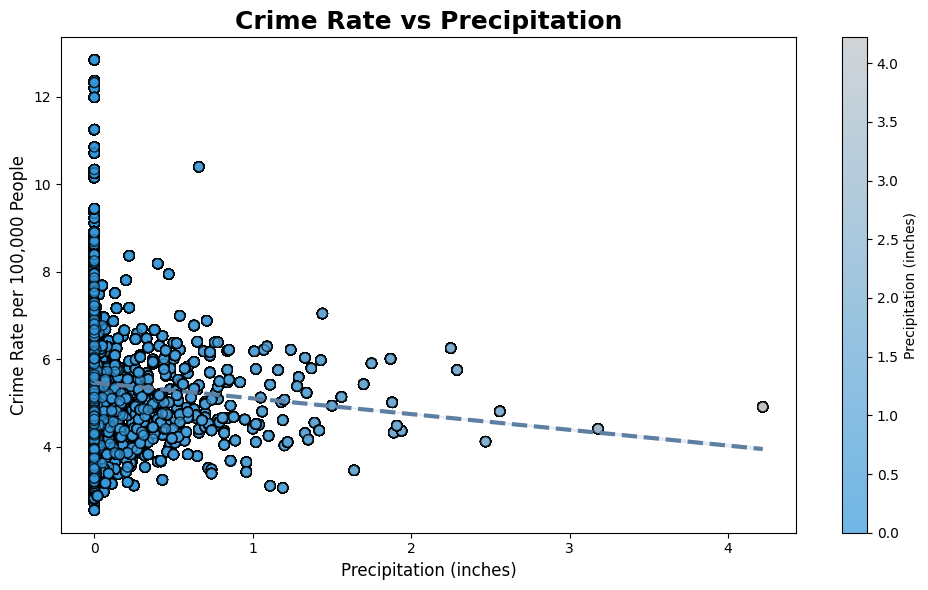

In [15]:
plt.figure(figsize=(10, 6))

# Create a custom colormap transitioning from blue to grey
custom_cmap = mcolors.LinearSegmentedColormap.from_list("blue_grey", ["#3498db", "#bdc3c7"])

# Scatter plot with custom colormap applied to precipitation values
scatter = plt.scatter(DomWeatherCrime_df['TotalPrecipitation'], DomWeatherCrime_df['CrimeRate'], 
                      c=DomWeatherCrime_df['TotalPrecipitation'], cmap=custom_cmap, alpha=0.7, s=50, edgecolor='black')

# Regression line with a subtle grey-blue color
sns.regplot(x=DomWeatherCrime_df['TotalPrecipitation'], y=DomWeatherCrime_df['CrimeRate'], 
            scatter=False, line_kws={'color': '#5d7fa1', 'lw': 3, 'linestyle': '--'})

# Add colorbar to show gradient transition
cbar = plt.colorbar(scatter)
cbar.set_label("Precipitation (inches)")

# Set the title and labels
plt.title("Crime Rate vs Precipitation", fontsize=18, fontweight='bold')
plt.xlabel("Precipitation (inches)", fontsize=12)
plt.ylabel("Crime Rate per 100,000 People", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

**Figure 5**

This scatterplot explores the relationship between precipitation and crime rates. The x-axis represents precipitation in inches, and the y-axis shows the crime rate. Most data points cluster near 0 inches, with crime rates decreasing as precipitation increases. This contradicts the hypothesis that bad weather increases indoor crimes, suggesting precipitation may not significantly influence domestic crime rates. However, the sparse data points at higher precipitation levels could indicate underreporting of crimes during severe weather, as individuals may be less likely to report incidents during storms.

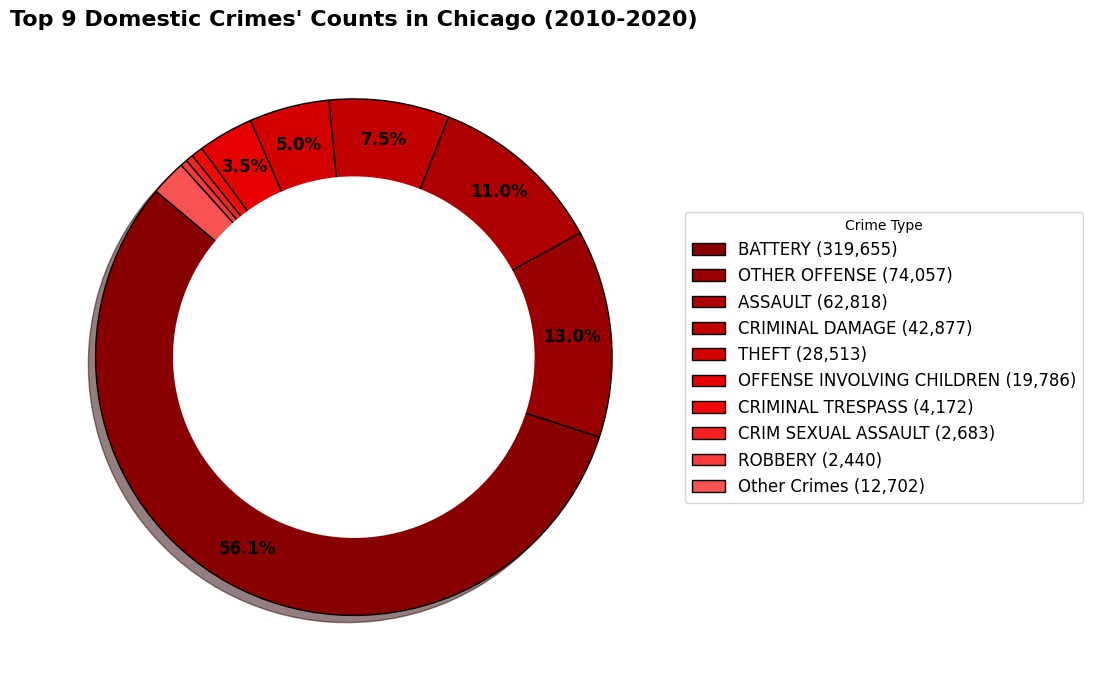

In [16]:
# Count occurrences of each primary crime type
crime_counts = DomWeatherCrime_df['Primary Type'].value_counts()

# Get the top 9 crimes
top_9_crimes = crime_counts.head(9)

# Group the rest as 'Other Crimes'
other_crimes = crime_counts.iloc[9:].sum()
top_9_crimes['Other Crimes'] = other_crimes

# Define custom colors for each pie segment
custom_colors = ['#880000', '#9b0000', '#ae0000', '#c10000', '#d40000', '#e70000', '#f30808', '#f52020', '#f73939', '#f95252']


# Create figure
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the pie chart with custom colors
wedges, texts, autotexts = ax.pie(
    top_9_crimes, 
    startangle=140, 
    colors=custom_colors,  # Use custom colors here
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},  # Black edges for clarity
    autopct=lambda p: f'{p:.1f}%' if p > 3 else '',  # Hide very small % labels
    textprops={'fontsize': 12, 'weight': 'bold'}, 
    pctdistance=0.85,  # Adjust % position
    shadow=True  # Adds depth
)

# Format the legend with crime type and count
labels = [f"{label} ({count:,})" for label, count in top_9_crimes.items()]
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Crime Type")

# Draw a center circle to create a "donut" effect for better clarity
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

# Set title
plt.title("Top 9 Domestic Crimes' Counts in Chicago (2010-2020)", fontsize=16, weight='bold')

# Ensure proper layout
plt.tight_layout()

# Show plot
plt.show()

**Figure 6**

This donut chart shows the distribution of the top 9 domestic crimes in Chicago. Battery is the most common (over 319,000 occurrences), while robbery is the least frequent (2,440 instances). This visualization highlights which crimes may be more susceptible to weather-related influences, such as battery and assault, which are more likely to occur indoors. Socioeconomically, this suggests that interventions targeting domestic violence during extreme weather should focus on crimes like battery, which are both prevalent and potentially influenced by environmental stressors.

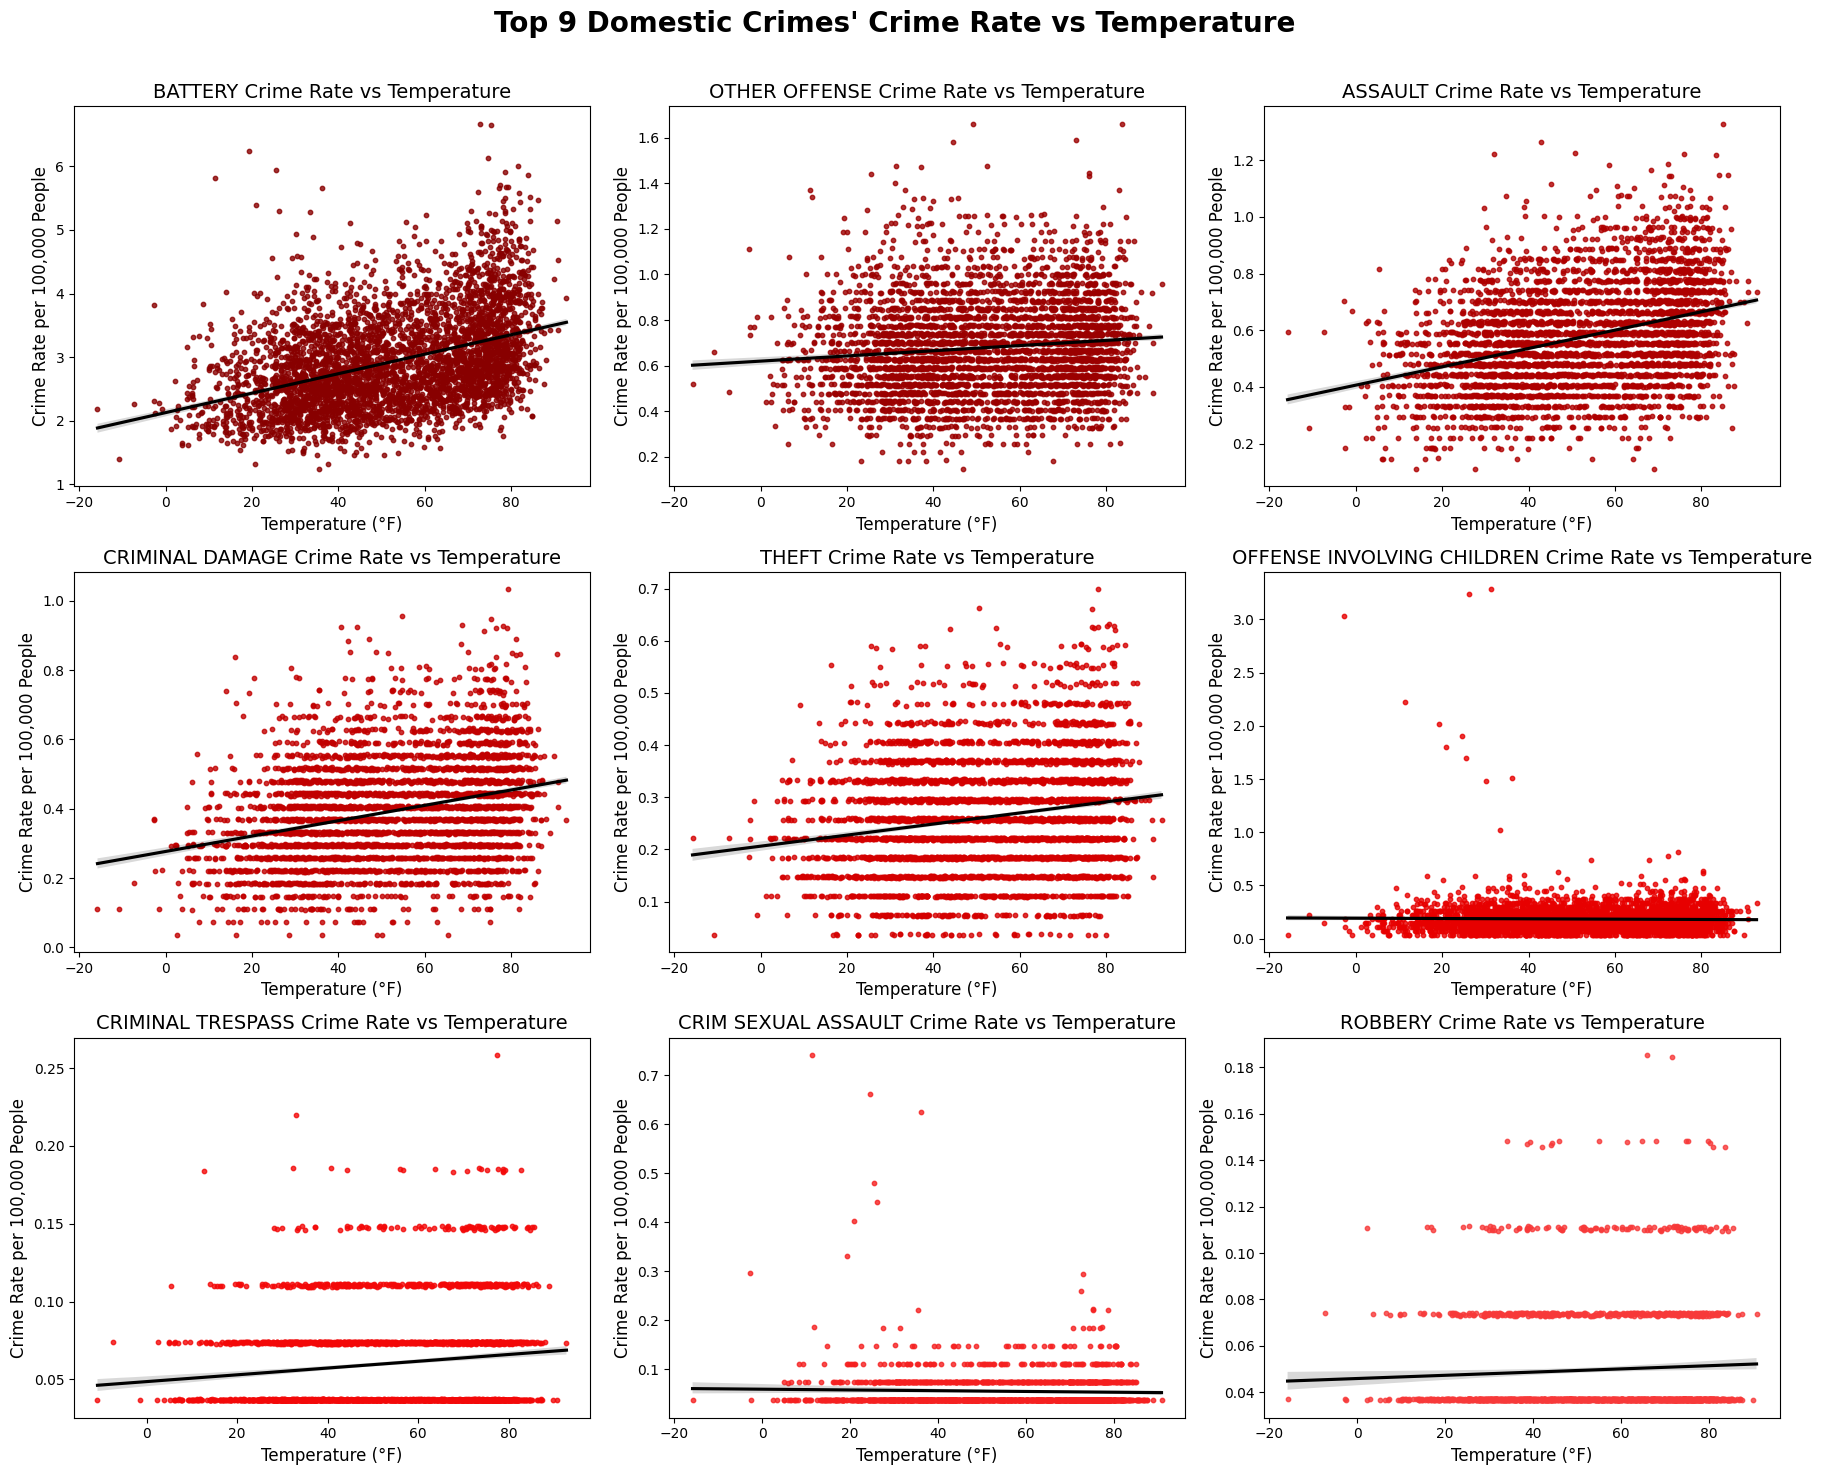

In [17]:
# Get the top 9 crime types based on occurrences
top_9_crime_types = DomWeatherCrime_df['Primary Type'].value_counts().head(9).index

# Filter the dataset to include only the top 9 crime types
filtered_data = DomWeatherCrime_df[DomWeatherCrime_df['Primary Type'].isin(top_9_crime_types)]

# Group by date and crime type to count instances per day
daily_crime_counts = filtered_data.groupby(['Date', 'Primary Type']).size().reset_index(name='CrimeCount')

# Merge the temperature data to get the AvgTemp for each date
daily_crime_counts = daily_crime_counts.merge(DomWeatherCrime_df[['Date', 'AvgTemp', 'Population']].drop_duplicates(), on='Date', how='left')

# Calculate the crime rate per 100,000 people (Crime Count / Population * 100000)
daily_crime_counts['CrimeRate'] = (daily_crime_counts['CrimeCount'] / daily_crime_counts['Population']) * 100000

# Create figure and axes for multiple subplots (3 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

fig.suptitle("Top 9 Domestic Crimes' Crime Rate vs Temperature", fontsize=20, fontweight='bold')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define a unique color palette for each crime type
colors = ['#880000', '#9b0000', '#ae0000', '#c10000', '#d40000', '#e70000', '#f30808', '#f52020', '#f73939', '#f95252']


# Plot for each of the top 9 crime types
for i, crime_type in enumerate(top_9_crime_types):
    crime_data = daily_crime_counts[daily_crime_counts['Primary Type'] == crime_type]
    
    # Plot regression line with scatterplot for each crime type, assigning a unique color to the dots
    sns.regplot(x=crime_data['AvgTemp'], y=crime_data['CrimeRate'], 
                data=crime_data, ax=axes[i], scatter_kws={'s': 10, 'color': colors[i]}, line_kws={'color': 'black'})
    
    # Set plot title and labels
    axes[i].set_title(f"{crime_type} Crime Rate vs Temperature", fontsize=14)
    axes[i].set_xlabel("Temperature (°F)", fontsize=12)
    axes[i].set_ylabel("Crime Rate per 100,000 People", fontsize=12)

# Adjust layout to avoid overlap

plt.tight_layout(rect=[0, 0, 1, .97])
plt.show()

**Figure 7**

These scatterplots show the relationship between temperature and crime rates for individual crime types. Most crimes, including battery and assault, increase with temperature, while offences involving children and criminal sexual assault show slight decreases. This suggests temperature affects different domestic crimes differently, with warmer weather increasing aggressive crimes and colder weather increasing sexual offences. Socioeconomically, this highlights the need for targeted interventions during specific weather conditions. For example, increased policing or community outreach during heatwaves could address rising battery and assault rates, while colder months may require more social support services to prevent child-related and sexual crimes.

## Conclusion

This study examines the relationship between weather conditions and domestic crime in Chicago, revealing that extreme temperatures—both high and low—are associated with increased domestic crime rates. Moderate humidity levels (50-60%) also correlate with higher crime rates, while extremely high humidity appears to suppress domestic violence. Precipitation, however, shows little correlation with crime, suggesting other factors may be more influential. These findings indicate that environmental stressors, such as heat-induced agitation or indoor confinement during cold weather, play a significant role in shaping domestic crime patterns.

These results have important implications for crime prevention. Law enforcement and social services can use weather-based crime forecasting to anticipate spikes in domestic violence during extreme weather, enabling proactive interventions such as increased outreach, resource allocation, and community support, mitigating the stressors that contribute to domestic violence.

Future research should explore additional factors, such as socioeconomic conditions, mental health variables, and seasonal trends, to gain a more comprehensive understanding of the relationship between weather and crime. Expanding the analysis to other cities could also determine whether these findings are unique to Chicago or part of broader national and global trends. By understanding the environmental triggers of domestic crime, we can develop more effective strategies to protect vulnerable populations and reduce household violence.

## References

#### Main Paper
- Ranson, M. (2014). "Crime, Weather, and Climate Change." Journal of Environmental Economics and Management, 67(3), 274-302.

#### Additional Papers
- Anderson, C. A., et al. (2000). "Temperature and Aggression." Advances in Experimental Social Psychology, 32, 63-133.
- Jacob, B., et al. (2007). "The Dynamics of Criminal Behavior: Evidence from Weather Shocks." Journal of Human Resources, 42(3), 489-527.
- Cohn, E. G., & Rotton, J. (2000). "Weather, Seasonal Trends, and Property Crimes in Minneapolis, 1987–1988." Journal of Environmental Psychology, 20(3), 257-272.
- Anderson, C. A. (2001). "Heat and Violence." Current Directions in Psychological Science, 10(1), 33-38.
- Horrocks, J., & Menclova, A. K. (2011). "The Effects of Weather on Crime." New Zealand Economic Papers, 45(3), 231-254.
- Baryshnikova, N., Davidson, S., & Wesselbaum, D. (2021). "Do You Feel the Heat Around the Corner? The Effect of Weather on Crime." Empirical Economics, 63(1), 179-199.
- Trujillo, J. C., & Howley, P. (2019). "The Effect of Weather on Crime in a Torrid Urban Zone." Journal of Environmental Economics and Management, 98, 102254.

#### Data
Sourced From:
- https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp/data
- https://www.wunderground.com/history/monthly/us/il/chicago/KMDW
- https://data.census.gov/